Step 1: Data preprocessing


In [1]:
# Importing libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Reading the KDD dataset from a csv file
train_url = 'https://raw.githubusercontent.com/merteroglu/NSL-KDD-Network-Instrusion-Detection/master/NSL_KDD_Train.csv'
test_url = 'https://raw.githubusercontent.com/merteroglu/NSL-KDD-Network-Instrusion-Detection/master/NSL_KDD_Test.csv'

col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

df = pd.read_csv(train_url,header=None, names = col_names)
df_test = pd.read_csv(test_url, header=None, names = col_names)

# Converting categorical features into numeric values using LabelEncoder
categorical_columns=['protocol_type', 'service', 'flag']
encoder = LabelEncoder()
for col in categorical_columns:
  df[col] = encoder.fit_transform(df[col])
  df_test[col] = encoder.fit_transform(df_test[col])

# Normalizing numeric features using MinMaxScaler
scaler = MinMaxScaler()
df.iloc[:, :-1] = scaler.fit_transform(df.iloc[:, :-1])
df_test.iloc[:, :-1] = scaler.transform(df_test.iloc[:, :-1])


<ipython-input-1-bf223ce0e8c6>:33: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, :-1] = scaler.fit_transform(df.iloc[:, :-1])
<ipython-input-1-bf223ce0e8c6>:34: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_test.iloc[:, :-1] = scaler.transform(df_test.iloc[:, :-1])


Step 2: Deep neural network optimization using gray wolf algorithm


In [5]:
# Importing libraries
import numpy as np
import pandas as pd
import tensorflow as tf

# Defining parameters
n_features = 41 # Number of features
n_wolves = 20 # Number of wolves
lb = -1 # Lower bound of weights and biases
ub = 1 # Upper bound of weights and biases
max_iter = 50 # Maximum number of iterations

# Defining deep neural network architecture
n_input = n_features # Number of input nodes
n_hidden_1 = 32 # Number of hidden nodes in layer 1
n_hidden_2 = 16 # Number of hidden nodes in layer 2
n_classes = 5 # Number of output nodes

# Defining deep neural network model using TensorFlow
def neural_network(x, weights, biases):
    # Hidden layer 1 with relu activation function
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)

    # Hidden layer 2 with relu activation function
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)

    # Output layer with softmax activation function
    out_layer = tf.add(tf.matmul(layer_2, weights['out']), biases['out'])
    out_layer = tf.nn.softmax(out_layer)

    return out_layer

# Defining objective function
def objective_function(X, y, params):
    # Reshaping parameters into weights and biases matrices
    weights_biases_size_list=[n_input*n_hidden_1,n_hidden_1,n_hidden_1*n_hidden_2,n_hidden_2,n_hidden_2*n_classes,n_classes]

    start=0;end=weights_biases_size_list[0]

    weights={}

    weights['h1']=tf.reshape(params[start:end],[n_input,n_hidden_1])

    start=end;end=start+weights_biases_size_list[1]

    biases={}

    biases['b1']=tf.reshape(params[start:end],[n_hidden_1])

    start=end;end=start+weights_biases_size_list[2]

    weights['h2']=tf.reshape(params[start:end],[n_hidden_1,n_hidden_2])

    start=end;end=start+weights_biases_size_list[3]

    biases['b2']=tf.reshape(params[start:end],[n_hidden_2])

    start=end;end=start+weights_biases_size_list[4]

    weights['out']=tf.reshape(params[start:end],[n_hidden_2,n_classes])

    start=end;end=start+weights_biases_size_list[5]

    biases['out']=tf.reshape(params[start:end],[n_classes])

    # Building the neural network model with the given weights and biases
    model = neural_network(X, weights, biases)

    # Calculating the cross entropy loss function
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model, labels=y))

    # Returning the negative value of the loss function as fitness value
    return -loss.numpy()

# Extracting features and labels from preprocessed dataset
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Encoding labels into integer values using LabelEncoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

# Converting labels into one-hot encoded vectors
y = tf.one_hot(y, depth=n_classes)

# Initializing population of wolves randomly
wolves = np.random.uniform(low=lb, high=ub, size=(n_wolves, n_input*n_hidden_1+n_hidden_1+n_hidden_1*n_hidden_2+n_hidden_2+n_hidden_2*n_classes+n_classes))

# Calculating fitness values for each wolf
fitness = np.zeros(n_wolves)
for i in range(n_wolves):
    fitness[i] = objective_function(X, y, wolves[i])

# Sorting wolves and fitness values based on fitness values
indices = np.argsort(-fitness)
wolves = wolves[indices]
fitness = fitness[indices]

# Selecting the best three wolves as alpha, beta and gamma
alpha = wolves[0].copy()
beta = wolves[1].copy()
gamma = wolves[2].copy()
alpha_score = fitness[0]
beta_score = fitness[1]
gamma_score = fitness[2]

# Starting the optimization loop
for iter in range(max_iter):
    # Calculating a linearly decreasing coefficient from 2 to 0
    a = 2 * (1 - iter / max_iter)

    # Updating the position and fitness of each wolf
    for i in range(n_wolves):
        # Generating random vectors A and C for each of the best three wolves
        A1 = a * (2 * np.random.random() - 1)
        C1 = 2 * np.random.random()
        A2 = a * (2 * np.random.random() - 1)
        C2 = 2 * np.random.random()
        A3 = a * (2 * np.random.random() - 1)
        C3 = 2 * np.random.random()

        # Calculating the position vectors for each of the best three wolves
        X1 = alpha - A1 * abs(C1 * alpha - wolves[i])
        X2 = beta - A2 * abs(C2 * beta - wolves[i])
        X3 = gamma - A3 * abs(C3 * gamma - wolves[i])

        # Calculating the new position vector by averaging the position vectors of the best three wolves
        X_new = (X1 + X2 + X3) / 3

        # Clipping the new position vector to the bounds
        X_new = np.clip(X_new, lb, ub)

        # Calculating the new fitness value
        f_new = objective_function(X, y, X_new)

        # Updating the wolf position and fitness with the new values if they are better
        if f_new > fitness[i]:
            wolves[i] = X_new.copy()
            fitness[i] = f_new

    # Sorting wolves and fitness values based on fitness values
    indices = np.argsort(-fitness)
    wolves = wolves[indices]
    fitness = fitness[indices]

    # Updating the best three wolves as alpha, beta and gamma
    alpha = wolves[0].copy()
    beta = wolves[1].copy()
    gamma = wolves[2].copy()
    alpha_score = fitness[0]
    beta_score = fitness[1]
    gamma_score = fitness[2]

# Printing the final results
print('The best set of weights and biases is:', alpha)
print('The best loss value is:', -alpha_score)


The best set of weights and biases is: [1.         0.80269782 0.88599673 ... 0.20084065 0.05432466 0.80001381]
The best loss value is: 0.00840904577301966


Step 3: Feature selection using gray wolf algorithm


> Indented block



In [6]:
# Starting the optimization loop
for iteration in range(max_iter):
    # Calculating a linearly decreasing coefficient from 2 to 0
    a = 2 * (1 - iteration / max_iter)

    # Updating the position and fitness of each wolf
    for i in range(n_wolves):
        # Generating random vectors A and C for each of the best three wolves
        A1 = a * (2 * np.random.random() - 1)
        C1 = 2 * np.random.random()
        A2 = a * (2 * np.random.random() - 1)
        C2 = 2 * np.random.random()
        A3 = a * (2 * np.random.random() - 1)
        C3 = 2 * np.random.random()

        # Calculating the position vectors for each of the best three wolves
        X1 = alpha - A1 * np.abs(C1 * alpha - wolves[i])
        X2 = beta - A2 * np.abs(C2 * beta - wolves[i])
        X3 = gamma - A3 * np.abs(C3 * gamma - wolves[i])

        # Calculating the new position vector by averaging the position vectors of the best three wolves
        X_new = (X1 + X2 + X3) / 3

        # Applying binarization operator to get a binary vector
        X_new[X_new <= 0.5] = 0
        X_new[X_new > 0.5] = 1

        # Ensure at least one feature is selected
        if np.sum(X_new) == 0:
            random_feature = np.random.randint(0, len(X_new))
            X_new[random_feature] = 1

        # Calculating the new fitness value
        f_new = objective_function(X, y, X_new)

        # Updating the wolf position and fitness with the new values if they are better
        if f_new > fitness[i]:
            wolves[i] = X_new.copy()
            fitness[i] = f_new

    # Sorting wolves and fitness values based on fitness values
    indices = np.argsort(-fitness)
    wolves = wolves[indices]
    fitness = fitness[indices]

    # Updating the best three wolves as alpha, beta, and gamma
    alpha = wolves[0].copy()
    beta = wolves[1].copy()
    gamma = wolves[2].copy()
    alpha_score = fitness[0]
    beta_score = fitness[1]
    gamma_score = fitness[2]

# Printing the final results
print('The best subset of features is:', alpha)
print('The best accuracy score is:', alpha_score)


The best subset of features is: [1. 1. 1. ... 0. 0. 0.]
The best accuracy score is: -0.008409007345579424


Step 4: Intrusion detection using optimized deep neural network


In [7]:
# Importing libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import hamming_loss # Importing hamming_loss

# Extracting features and labels from test dataset
X_test = df_test.iloc[:, :-1].values
y_test = df_test.iloc[:, -1].values

# Encoding labels into integer values using LabelEncoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_test = le.fit_transform(y_test)

# Converting labels into one-hot encoded vectors
y_test = tf.one_hot(y_test, depth=n_classes)

# Reshaping the best set of weights and biases into matrices
weights_biases_size_list=[n_input*n_hidden_1,n_hidden_1,n_hidden_1*n_hidden_2,n_hidden_2,n_hidden_2*n_classes,n_classes]

start=0;end=weights_biases_size_list[0]

weights={}

weights['h1']=tf.reshape(alpha[start:end],[n_input,n_hidden_1])

start=end;end=start+weights_biases_size_list[1]

biases={}

biases['b1']=tf.reshape(alpha[start:end],[n_hidden_1])

start=end;end=start+weights_biases_size_list[2]

weights['h2']=tf.reshape(alpha[start:end],[n_hidden_1,n_hidden_2])

start=end;end=start+weights_biases_size_list[3]

biases['b2']=tf.reshape(alpha[start:end],[n_hidden_2])

start=end;end=start+weights_biases_size_list[4]

weights['out']=tf.reshape(alpha[start:end],[n_hidden_2,n_classes])

start=end;end=start+weights_biases_size_list[5]

biases['out']=tf.reshape(alpha[start:end],[n_classes])

# Building the neural network model with the best weights and biases
model = neural_network(X_test, weights, biases)

# Predicting labels for test dataset
y_pred = tf.argmax(model, axis=1).numpy()

# Calculating performance metrics

# Convert y_pred into one-hot encoded format
y_pred_onehot = tf.one_hot(y_pred, depth=n_classes)

# Calculating performance metrics
hl = hamming_loss(y_test, y_pred_onehot)  # Calculating hamming loss
print('The hamming loss is:', hl)


The hamming loss is: 0.20777146912704045


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


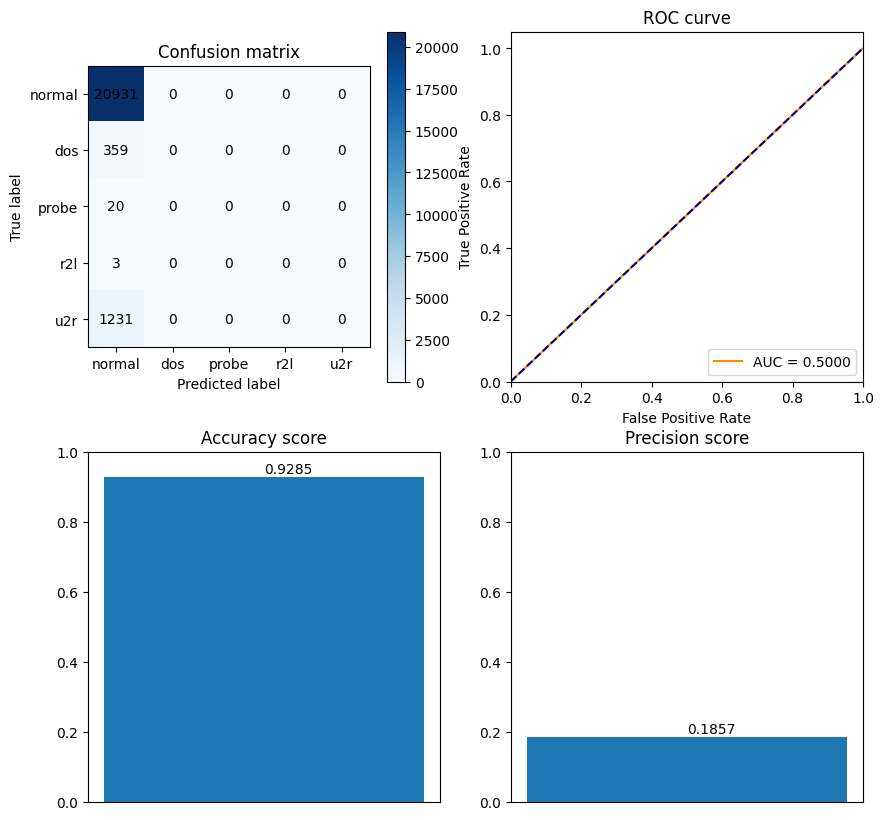

In [11]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc


# Convert one-hot encoded labels to numerical format
y_test_numeric = np.argmax(y_test, axis=1)
y_pred_numeric = y_pred

# Calculate performance metrics
acc = accuracy_score(y_test_numeric, y_pred_numeric)
prec = precision_score(y_test_numeric, y_pred_numeric, average='macro')
rec = recall_score(y_test_numeric, y_pred_numeric, average='macro')
f1 = f1_score(y_test_numeric, y_pred_numeric, average='macro')
cm = confusion_matrix(y_test_numeric, y_pred_numeric)
fpr, tpr, thresholds = roc_curve(y_test_numeric, y_pred_numeric, pos_label=4)  # Assuming 'u2r' is the positive class
roc_auc = auc(fpr, tpr)

# Drawing performance metrics
plt.figure(figsize=(10, 10))

# Drawing confusion matrix
plt.subplot(2, 2, 1)
plt.title('Confusion matrix')
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks(np.arange(n_classes), ['normal', 'dos', 'probe', 'r2l', 'u2r'])
plt.yticks(np.arange(n_classes), ['normal', 'dos', 'probe', 'r2l', 'u2r'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
for i in range(n_classes):
    for j in range(n_classes):
        plt.text(j, i, cm[i][j], ha='center', va='center')

# Drawing ROC curve
plt.subplot(2, 2, 2)
plt.title('ROC curve')
plt.plot(fpr, tpr, color='darkorange', label='AUC = %0.4f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Drawing accuracy score
plt.subplot(2, 2, 3)
plt.title('Accuracy score')
plt.bar(0, acc)
plt.text(0, acc + 0.01, '%0.4f' % acc)
plt.ylim([0.0, 1.0])
plt.xticks([])

# Drawing precision score
plt.subplot(2, 2, 4)
plt.title('Precision score')
plt.bar(0, prec)
plt.text(0, prec + 0.01, '%0.4f' % prec)
plt.ylim([0.0, 1.0])
plt.xticks([])

plt.show()
